In [1]:
import os
from datetime import datetime
from hashlib import sha256

import pandas as pd
import numpy as np

# -------------------------
# model libs
from pycaret.classification import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# -------------------------
# model validation and hyperparameter tunning libs
from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import (precision_recall_curve, average_precision_score, classification_report, roc_curve)

from yellowbrick import ROCAUC

# -------------------------
# graph libs
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

os.chdir("../src/")
from utils.data_describe import DataDescribe as dd
from utils.classification_model_evaluation import ClassificationModelEvaluation as cme

basepath = "../data/external/"
path_x_train = "../data/external/train_values.csv"
path_y_train = "../data/external/train_labels.csv"
path_x_test = "../data/external/test_values.csv"

path_x_selected = "../data/interim/"
path_processed = "../data/processed/"
path_model = "../models/"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# load the autoreload extension
%load_ext autoreload

# Set extension to reload modules every time before executing code
%autoreload 2

In [2]:
# List all files in a directory using scandir()
print("-"*30)
print(f"Arquivos em {path_processed}:\n")

with os.scandir(path_processed) as entries:
    for entry in entries:
        if entry.is_file() and (("csv" in entry.name) or ("pqt" in entry.name)):
            print(entry.name)

print("-"*30)

------------------------------
Arquivos em ../data/processed/:

X_test_encoded.csv
X_test_encoded.pqt
df_train.pqt
model_evaluation.csv
y_test.csv
y_test_2020-12-12.csv
y_test_20201212.csv
y_test_20201213.csv
------------------------------


# Carregando dataframe da preparação de dados

In [4]:
df_train = pd.read_parquet(path_processed+"df_train.pqt")
print(f"Dimensão do dataset de treinamento: {df_train.shape}.")
df_train.head()

Dimensão do dataset de treinamento: (260601, 53).


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_t,land_surface_condition_o,roof_type_n,roof_type_q,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_r,other_floor_type_q,other_floor_type_x,other_floor_type_j,position_t,position_s,position_j,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,ground_floor_type_f,ground_floor_type_x,ground_floor_type_v,ground_floor_type_z,plan_configuration_d,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,3
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,2
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,3
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,2
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,3


In [5]:
X = df_train.drop(["damage_grade"], axis=1)
y = df_train["damage_grade"]

n_splits = 5
n_repeats = 3
random_state = 42
scoring = "f1_macro"

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=random_state)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

### Light Gradient Boosting (LightGBM)

In [9]:
%%time

dct_lgbm_core_params = {"random_state":random_state, "n_jobs":-1, "objective":"multiclass", "num_class":3, "num_iterations":500,
                        "boosting_type":"gbdt", "learning_rate":.075, "n_estimators":1500, "max_depth":25, "num_leaves":150}

model_lgbm = LGBMClassifier(**dct_lgbm_core_params)

n_scores = cross_val_score(model_lgbm, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"{scoring}: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

f1_macro: média: 0.685  desvio padrão: 0.002
Wall time: 2min 8s


In [10]:
%%time

model_lgbm = LGBMClassifier(**dct_lgbm_core_params)

model_lgbm.fit(X_train, y_train)

y_pred = model_lgbm.predict(X_validation)
y_pred_proba = model_lgbm.predict_proba(X_validation)

classification_report_dict = classification_report(y_validation, y_pred, output_dict=True)

Wall time: 14.3 s


# Otimização de hiperparâmetros

## Tunning do Light Gradient Boosting

Inicialmente, faremos o tunning sobre o Light Gradient Boosting, pois é o que possui menor tempo de execução (para comparação, o Extreme Gradient Boosting levou 17x mais que o Light Gradient Boosting, cerca de 60 min contra 3,5 min do LightGBM).

In [106]:
# %%time

# model_lgbm = LGBMClassifier(**dct_lgbm_core_params)

# params = {"boosting_type":["gbdt"],
#           "learning_rate":[.075],
#           "n_estimators":[1500],
#           "max_depth":[25],
#           "num_leaves":[150],
#           "class_weight":[None]}

# grid_search = GridSearchCV(estimator=model_lgbm, param_grid=params,
#                            scoring=scoring, cv=cv, n_jobs=-1)

# grid_search = grid_search.fit(X, y)

# print(f"Melhores parâmetros obtidos: {print(grid_search.best_params_)}")

{'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.075, 'max_depth': 25, 'n_estimators': 1500, 'num_leaves': 150}
Melhores parâmetros obtidos: None
Wall time: 3min 24s


In [19]:
# {'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.075, 'max_depth': 20, 'n_estimators': 1500, 'n_jobs': -1, 'num_leaves': 120}

In [12]:
# grid_search.score(X, y)

0.7777681159579628

### Avaliando o modelo

In [19]:
y_pred = model_lgbm.predict(X_validation)
y_pred_proba = model_lgbm.predict_proba(X_validation)

result = cme.classification_metrics_in_dataframe(y_validation, y_pred, model_lgbm)

result

,model,precision,recall,f1-score,support,accuracy,params,date
-3471169731629123431,LGBMClassifier,0.730536,0.662771,0.688804,78181,0.74238,"{'boosting_type': 'gbdt', 'class_weight': None...",2020-12-13


In [20]:
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape)
print(y_pred.shape, y_pred_proba.shape)
pd.DataFrame(y_pred).value_counts()

(182420, 52) (182420,) (78181, 52) (78181,)
(78181,) (78181, 3)


2    50978
3    21575
1     5628
dtype: int64

In [21]:
df_y_pred = pd.DataFrame(y_pred_proba, columns=[1,2,3])
df_y_pred["y_pred"] = y_pred
df_y_pred["y_validation"] = y_validation.values

df_y_pred.head(10)

,1,2,3,y_pred,y_validation
0,0.008828,0.303795,0.687377,3,2
1,0.073322,0.797374,0.129303,2,2
2,0.037432,0.650989,0.311579,2,2
3,0.000355,0.882065,0.117580,2,2
4,0.004479,0.895343,0.100177,2,2
5,0.008640,0.921993,0.069368,2,2
6,0.006000,0.464455,0.529545,3,2
7,0.003484,0.746776,0.249740,2,2
8,0.001559,0.471800,0.526640,3,3
9,0.001209,0.072581,0.926210,3,3


In [22]:
df_y_pred.shape
df_y_pred_misclassification = df_y_pred.loc[df_y_pred["y_pred"]!=df_y_pred["y_validation"],:]
print(f"""Total: {df_y_pred.shape[0]}
Classificados erroneamente: {df_y_pred_misclassification.shape[0]}
Proporção: {round(100*df_y_pred_misclassification.shape[0]/df_y_pred.shape[0], 2)}%""")

Total: 78181
Classificados erroneamente: 20141
Proporção: 25.76%


<AxesSubplot:xlabel='y_validation', ylabel='count'>

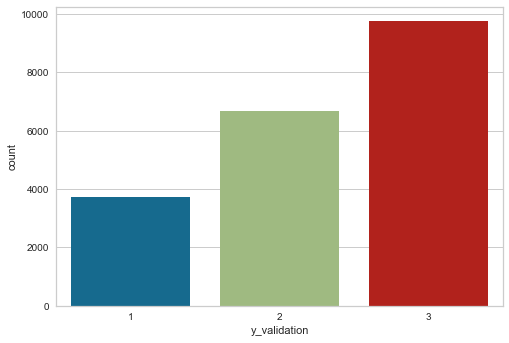

In [23]:
df_y_pred_misclassification["pares"] = df_y_pred_misclassification["y_pred"].apply(str)+"-"+df_y_pred_misclassification["y_validation"].apply(str)
sns.countplot(df_y_pred_misclassification["y_validation"])

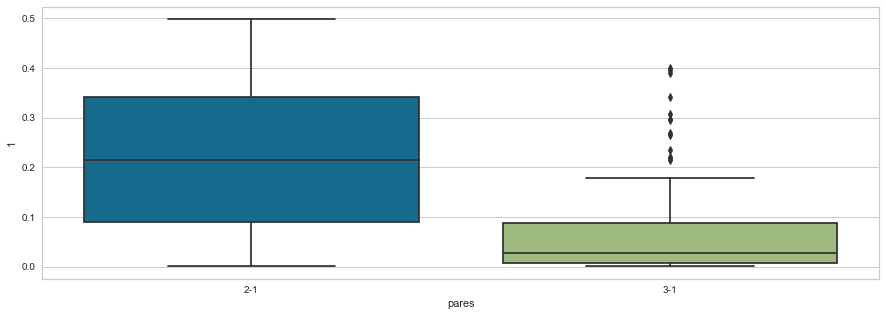

In [24]:
plt.figure(figsize=(15,5))

df_temp = df_y_pred_misclassification.loc[df_y_pred_misclassification["pares"].str.contains('-1')]
ax = sns.boxplot(x="pares", y=1, data=df_temp, order=sorted(df_temp["pares"].unique()))

In [25]:
(df_y_pred_misclassification.groupby(["pares"]).agg({1:'median', 2:'median', 3:'median'}))

,1,2,3
pares,,,
1-2,0.609818,0.351644,0.017128
1-3,0.567240,0.318030,0.076323
2-1,0.214433,0.678934,0.078018
2-3,0.007808,0.683552,0.278669
3-1,0.026801,0.328511,0.587055
3-2,0.002555,0.361502,0.630714


In [27]:
X_test_encoded = pd.read_parquet(path_processed+"X_test_encoded.pqt")
X_test_encoded.head()

y_test = model_lgbm.predict(X_test_encoded)
y_test = pd.DataFrame(data=y_test, columns=["damage_grade"], index=X_test_encoded.index)

today = str(datetime.today().date())
today = today.replace('-', '')

y_test.to_csv(path_processed+"y_test_"+today+".csv")